#### Installation

In [2]:
#!pip install git+https://www.github.com/huggingface/transformers
#!pip install git+https://github.com/huggingface/accelerate
#!pip install bitsandbytes
#!pip install einops
#!pip install --upgrade torch torchvision
#!pip install scikit-learn
#!pip install matplotlib
#!pip install datasets
#!pip install Bio
#!pip install pybedtools
#!pip install tabulate

### Libraries (some in utility_fuction.py)

In [3]:
# Hugging Face Datasets library
from datasets import load_dataset, Dataset

# Scikit-learn for evaluation and data splitting
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Biopython for sequence processing
from Bio import SeqIO

# PyBedTools for genomic interval manipulation
from pybedtools import BedTool

# Data analysis and scientific computation
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyTorch for deep learning
import torch
from torch import nn

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities and external libraries
import os
import pickle
import genopyc
import utility_functions as uf # Custom utility functions for loading models/tokenizers, datasets from the experiments

from concurrent.futures import ThreadPoolExecutor
import time

# Configure Seaborn for better plotting aesthetics
sns.set()

2025-01-21 10:54:28.066232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 10:54:28.066268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 10:54:28.067195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 10:54:28.072647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 10:54:29.863360: W tensorflow/compiler/tf2

### Parameters (load models for prediction)

In [4]:
# model name from huggingface.co/model name_id:model_name
models_names = [
 'dnabert2',
 'nucleotide-transformer-v2-50m-multi-species',
 'nucleotide-transformer-v2-100m-multi-species',
 'nucleotide-transformer-v2-250m-multi-species',
 'nucleotide-transformer-v2-500m-multi-species',
 'nucleotide-transformer-500m-1000g',
 'nucleotide-transformer-500m-human-ref',
 'nucleotide-transformer-2.5b-1000g',
 'nucleotide-transformer-2.5b-multi-species',
 'Geneformer',
 'gena-lm-bert-base-t2t',
 'gena-lm-bert-large-t2t',
 'gena-lm-bert-base-t2t-multi',
 'gena-lm-bigbird-base-t2t',
 'hyenadna-small-32k-seqlen-hf',
 'hyenadna-medium-160k-seqlen-hf',
 'hyenadna-medium-450k-seqlen-hf',
 'hyenadna-large-1m-seqlen-hf'
 ]

# type of fine-tuned
ft_model_type = '1kbpHG19_DHSs_H3K27AC'

# samples for fine-tuning
#'BioS2'=Hela, 'BioS45'=neural progenitor cell, 'BioS73'=hepg2, 'BioS74'=k562
bios_ids = ['BioS2', 'BioS45', 'BioS73', 'BioS74']

# load chrom2seq hg38 and hg19
with open(f'/data/Dcode/gaetano/repos/AI4Genomic/data/chrom2seqHG38.pkl', "rb") as pickle_file:
    chrom2seqHG38 = pickle.load(pickle_file)    

with open(f'/data/Dcode/gaetano/repos/AI4Genomic/data/chrom2seqHG19.pkl', "rb") as pickle_file:
    chrom2seqHG19 = pickle.load(pickle_file)

## Main

#### Load experiment dataset

In [5]:
data_to_source = pd.read_csv('/data/Dcode/gaetano/repos/AI4Genomic/data/data_mutagenesis_curated.csv')
data_to_source

,name,path,hg type,#samples,cell line,study,resource,BioS,type_data
0,k562.sign.id.LP190708.txt,/data/Dcode/gaetano/repos/AI4Genomic/data/raQT...,hg19,19237,k562,PMID: 31253979,https://osf.io/6y9td/,BioS74,raQTL
1,hepg2.sign.id.LP190708.txt,/data/Dcode/gaetano/repos/AI4Genomic/data/raQT...,hg19,14183,hepg2,PMID: 31253979,https://osf.io/6y9td/,BioS73,raQTL
2,SORT1.csv,/data/Dcode/gaetano/repos/AI4Genomic/data/mpra...,hg38,1789,hepg2,PMID: 31395865,https://pavlopoulos-lab.org/shinyapps/app/mpra...,BioS73,mpra
3,GSE87711.csv,/data/Dcode/gaetano/repos/AI4Genomic/data/mpra...,hg19,84,k562,PMID: 27259154,paper Sup. Mat.,BioS74,mpra
4,GSE68331_SNP.csv,/data/Dcode/gaetano/repos/AI4Genomic/data/mpra...,hg19,283,hepg2,PMID: 26084464,paper Sup. Mat.,BioS73,mpra
5,NPC_SNP.csv,/data/Dcode/gaetano/repos/AI4Genomic/data/mpra...,hg19,14042,NPC,PMID: 33885362,paper Sup. Mat.,BioS45,mpra
6,Hela_TRAF3IP2.csv,/data/Dcode/gaetano/repos/AI4Genomic/data/mpra...,hg19,1962,Hela,PMID: 25340400,paper Sup. Mat.,BioS2,mpra
7,Hela_PPARG.csv,/data/Dcode/gaetano/repos/AI4Genomic/data/mpra...,hg19,1614,Hela,PMID: 25340400,paper Sup. Mat.,BioS2,mpra
8,Hela_SORL1.csv,/data/Dcode/gaetano/repos/AI4Genomic/data/mpra...,hg19,1665,Hela,PMID: 25340400,paper Sup. Mat.,BioS2,mpra


### preprocess experimental dataset

In [6]:
idx = 1
data_ = data_to_source.iloc[idx]

# extract from dataset
dataset_df = uf.data_preprocessing_experimental_result(data_['type_data'], data_['name'], data_['path'])
print(data_['type_data'], data_['name'])
dataset_df

raQTL hepg2.sign.id.LP190708.txt


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Chromosome,Position,Reference,Alternative,SNP_id,Value_Ratio,Value_Diff,Value_Ratio_log2,Value_Pvalue_signed,P_value
0,chr3,24362252,A,G,rs9814223,22.967045,34.702011,4.521493,39.298515,5.029041e-40
1,chr4,59436721,T,C,rs1605769,10.555441,13.601881,3.399915,35.605309,2.481365e-36
2,chr5,54253581,A,G,rs3815923,0.071947,-12.461018,-3.796916,-35.227522,5.922130e-36
3,chr9,88698591,C,A,rs1928227,14.642079,10.962843,3.872049,34.837753,1.452938e-35
4,chr14,89393045,G,A,rs7156067,0.053868,-14.728486,-4.214426,-34.683354,2.073221e-35
...,...,...,...,...,...,...,...,...,...,...
14178,chr22,39493251,T,A,rs41281251,0.509928,-11.933327,-0.971633,-2.762209,1.728983e-03
14179,chr1,201987924,C,T,rs80059802,0.533668,-2.211725,-0.905986,-2.762030,1.729699e-03
14180,chr2,122050796,G,A,rs934939,1.934232,6.365521,0.951761,2.761880,1.730296e-03
14181,chr11,21053752,C,G,rs4923282,1.198240,1.426730,0.260917,2.761710,1.730972e-03


### Load Ld data

In [7]:
## open pickle 
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/ld/ld_{data_['name']}.pkl", "rb") as pickle_file:
    ld_blocks = pickle.load(pickle_file)

print(f"Loaded LD dictionary for {data_['name']}")

Loaded LD dictionary for hepg2.sign.id.LP190708.txt


#### open dict of LDs  

In [8]:
## open pickle 
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/ld/ld_{data_['name']}.pkl", "rb") as pickle_file:
    ld_dict = pickle.load(pickle_file)

print(f"Loaded LD dictionary for {data_['name']}")

Loaded LD dictionary for hepg2.sign.id.LP190708.txt


#### Open LD dataframe

In [9]:
## load dataframe 
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/ld/ld_df_{data_['name']}.pkl", "rb") as pickle_file:
    df = pickle.load(pickle_file)

print(f"Loaded LD dataframe for {data_['name']}")

Loaded LD dataframe for hepg2.sign.id.LP190708.txt


In [10]:
condition = (df['Chromosome']!='chrHSCHR22_1_CTG7') & (df['Chromosome']!='chrHSCHR11_3_CTG1') & (df['Chromosome']!='chrHG1651_PATCH')

df_filtered = df[condition]

df_filtered.to_csv(f'/data/Dcode/gaetano/repos/AI4Genomic/data/ld/ld_df_hepg2.sign.id.LP190708.txt.csv', index=False)

In [11]:
causal_snp_list = list(set(df_filtered['SNP_id_candidate']))
causal_snp_list

ld_list = list(df_filtered['SNP_id'])

def intersection(list1, list2):
    return [value for value in list1 if value in list2]

causal_snp_list_no_overlaps = []
for causal_snp in causal_snp_list: 
    ld_list = list(df_filtered[df_filtered['SNP_id_candidate']==causal_snp]['SNP_id'])
    overlaps = intersection(ld_list, causal_snp_list)
    if len(overlaps) == 0:
        causal_snp_list_no_overlaps.append(causal_snp)


### Load prediction

In [12]:
## load pickle
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/tmp_ld_predictions_{data_['name']}.pkl", "rb") as pickle_file:
    models_predictions = pickle.load(pickle_file)

print(f"Loaded LD predictions for {data_['name']}")

Loaded LD predictions for hepg2.sign.id.LP190708.txt


In [13]:
## load ld prediction trednet repos/AI4Genomic/data/predictions/trednet_LD_hepg2.pkl 
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/trednet_LD_hepg2.pkl", "rb") as pickle_file:
    trednet_predictions = pickle.load(pickle_file,encoding='latin1')

## load ld prediction enformer repos/AI4Genomic/data/predictions/enformer_LD_hepg2.sign.id.LP190708.txt.pkl 
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/enformer_LD_hepg2.sign.id.LP190708.txt.pkl", "rb") as pickle_file:
    enformer_predictions = pickle.load(pickle_file,encoding='latin1')

## load ld prediction sei /data/Dcode/gaetano/CNNplusModels/sei-framework/sei_pred_hepg2.sign.id.LP190708.txt.pkl 
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/sei_pred_hepg2.sign.id.LP190708.txt.pkl", "rb") as pickle_file:
    sei_predictions = pickle.load(pickle_file,encoding='latin1')



    
models_predictions['trednet_ft_BioS73'] = trednet_predictions
models_predictions['enformer_ft_BioS73'] = enformer_predictions 
models_predictions['sei_ft_BioS73'] = sei_predictions


In [14]:
# Initialize borzoi_predictions dictionary
borzoi_predictions = {
    'diff': np.array([]),
    'diff_ratio': np.array([])
}

# Define the base path and filename format
base_path = "/data/Dcode/gaetano/CNNplusModels/baskerville/borzoi/examples/borzoi_models_sample/results"
filename_format = "borzoi_LD_hepg2.sign.id.LP190708.txt_{idx}_predictions.pkl"

# Load and process predictions for indices 1 to 10
for idx in range(1, 11):
    file_path = f"{base_path}/{filename_format.format(idx=idx)}"
    with open(file_path, "rb") as pickle_file:
        diff_ratio_predictions = pickle.load(pickle_file, encoding='latin1')
        borzoi_predictions['diff'] = np.append(borzoi_predictions['diff'], diff_ratio_predictions['diff'])
        borzoi_predictions['diff_ratio'] = np.append(borzoi_predictions['diff_ratio'], diff_ratio_predictions['diff_ratio'])
        

models_predictions['borzoi_ft_BioS73'] = borzoi_predictions

### calculate log2 fold change prediction for assosiated snps (r2>0.8)

In [15]:
def calculate_logit_ratio(ref_predictions, alt_predictions):
    """Calculate the log2 ratio of alt and ref probabilities using the sigmoid function."""
    ref_margin_logit = ref_predictions[:, 1] - ref_predictions[:, 0]
    alt_margin_logit = alt_predictions[:, 1] - alt_predictions[:, 0]

    ref_probability = 1 / (1 + np.exp(-ref_margin_logit))
    alt_probability = 1 / (1 + np.exp(-alt_margin_logit))

    return np.log2((alt_probability / ref_probability).numpy())



### Get prediction for assosiated SNPs

In [16]:
candidate_snps = df['SNP_id_candidate'].value_counts()
snp_cand_dict = {}

# Iterate through models
for model_version in models_predictions.keys():
    # Initialize starting index for each model
    start_idx = 0
    
    for snp_cand_id, snp_cand_count in candidate_snps.items():
        end_idx = start_idx + snp_cand_count  # Calculate end index
        
        # Initialize the SNP candidate entry if it doesn't exist
        if snp_cand_id not in snp_cand_dict:
            snp_cand_dict[snp_cand_id] = {}
        
        # Initialize the model_version dictionary for this SNP candidate
        if model_version not in snp_cand_dict[snp_cand_id]:
            snp_cand_dict[snp_cand_id][model_version] = {}
        
        # Slice predictions for 'ref' and 'alt'
        if 'trednet' in model_version: 
            ref_probability =  trednet_predictions['predictions_ref'][start_idx:end_idx]
            alt_probability =  trednet_predictions['predictions_alt'][start_idx:end_idx]
            snp_cand_dict[snp_cand_id][model_version] = {
            'ref': ref_probability,
            'alt': alt_probability,
            }
            snp_cand_dict[snp_cand_id][model_version]['log2_ratio'] = np.log2(np.squeeze(alt_probability / ref_probability))
        elif 'enformer' in model_version:
            snp_cand_dict[snp_cand_id][model_version] = {
            'log2_ratio': np.log2(enformer_predictions['diff_ratio'][start_idx:end_idx]),
            }
        elif 'sei' in model_version:
            snp_cand_dict[snp_cand_id][model_version] = {
            'log2_ratio': np.log2(sei_predictions['diff_ratio'][start_idx:end_idx]),
            }
        elif 'borzoi' in model_version:
            snp_cand_dict[snp_cand_id][model_version] = {
            'log2_ratio': np.log2(sei_predictions['diff_ratio'][start_idx:end_idx]),
            }
        else:    
       
            snp_cand_dict[snp_cand_id][model_version] = {
                'ref': models_predictions[model_version]['ref'][start_idx:end_idx],
                'alt': models_predictions[model_version]['alt'][start_idx:end_idx],
            }
            
            snp_cand_dict[snp_cand_id][model_version]['log2_ratio'] = calculate_logit_ratio(snp_cand_dict[snp_cand_id][model_version]['ref'], snp_cand_dict[snp_cand_id][model_version]['alt'])  
        
        # Update the starting index for the next SNP candidate
        start_idx = end_idx

### Load casual snps predictions in log2 fold-change

In [16]:
def load_pickle_predictions(file_path):
    """Load a pickle file and return its contents."""
    with open(file_path, 'rb') as file:
        return pickle.load(file, encoding='latin1')

def get_model_predictions(data, models_to_add, data_name):
    """Generate model predictions from data, including additional models."""
    model_predictions = {}

    # Process existing models
    for model, values in data.items():
        model_name = model.split('_')[0]
        model_predictions[model_name] = {
            'Value_Ratio_log2': calculate_logit_ratio(values['ref'], values['alt'])
        }

    # Add external models
    for model_name in models_to_add:
        path_model_pred = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{model_name}_{data_name}.pkl'
        external_data = load_pickle_predictions(path_model_pred)

        if 'tred' in model_name:
            external_data['diff_ratio'] = np.squeeze(external_data['predictions_alt'] / external_data['predictions_ref'])
        
        diff_ratio = external_data.get('diff_ratio', [])
        if not isinstance(diff_ratio, np.ndarray):
            diff_ratio = np.array(diff_ratio)

        model_predictions[model_name] = {
            'Value_Ratio_log2': np.log2(diff_ratio)
        }

    return model_predictions

def get_prediction_ratio_per_experiment(data_to_source):
    """Main function to compute prediction ratios for each experiment."""
    dict_results_per_experiment = {}

    for index, row in data_to_source.iterrows():
        data_name = row['name']
        dataset_path = row['path']
        type_data = row['type_data']

        # Preprocess data and load model predictions
        data_df = uf.data_preprocessing_experimental_result(type_data, data_name, dataset_path)
        file_path = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{data_name}.pkl'
        data = load_pickle_predictions(file_path)

        # Get all model predictions
        models_to_add = ['trednet', 'sei', 'enformer', 'borzoi']
        model_predictions = get_model_predictions(data, models_to_add, data_name)
        dict_results_per_experiment[index] = model_predictions

    return dict_results_per_experiment

dict_results_per_experiment = get_prediction_ratio_per_experiment(data_to_source)

/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

In [27]:
model_to_casual_snp = {}

for model_to_check in list(dict_results_per_experiment[0].keys()):
    val_no_ld = 0
    val_ld_casual = 0
    top_1 = 0
    top_2 = 0
    top_3 = 0
    top_5 = 0
    for cas_snp in snp_cand_dict.keys():
        # Get the experiment log2 values for the current SNP
        experiment_log2 = dataset_df[dataset_df['SNP_id'] == cas_snp]['Value_Ratio']


        # Extract the log2 values for the casual SNP from the ndarray (assuming it's an array)
        casual_snp_log2 = dict_results_per_experiment[1][model_to_check]['Value_Ratio_log2']

        # Ensure experiment_log2.index corresponds to valid indices in the casual_snp_log2 array
        # If experiment_log2.index is not a simple integer index, convert it to a positional index.
        # We assume experiment_log2.index contains the row positions from the original dataframe.

        try:
            index_positions = np.isin(np.arange(len(casual_snp_log2)), experiment_log2.index)
        except AttributeError:
            # If experiment_log2.index is not present, default to checking the index directly
            index_positions = np.isin(np.arange(len(casual_snp_log2)), list(experiment_log2.index))

        # Ensure that the boolean indexing matches the casual_snp_log2 array length
        if sum(index_positions) == 0:
            print(f"Warning: No matching indices found for SNP {cas_snp} in experiment_log2")
            continue  # Skip this SNP if no matching indices are found

        # Get the values from casual_snp_log2 at the corresponding positions
        casual_snp_log2_value = casual_snp_log2[index_positions]

        # Check if we have multiple log2 values or just one for the casual SNP
        if len(casual_snp_log2_value) > 1:
            casual_snp_log2_value = casual_snp_log2_value[0]  # Assuming you need only one value

        # Extract associated SNP log2 values from the dictionary
        associated_snps_log2 = snp_cand_dict[cas_snp].get(f'{model_to_check}_ft_BioS73', {}).get('log2_ratio', [])

        # If associated_snps_log2 is a scalar (single value)
        if isinstance(associated_snps_log2, (int, float, np.float32, np.float64)):
            associated_snps_log2 = [associated_snps_log2]  # Convert scalar to list for uniformity

        # Now, associated_snps_log2 should always be a list or an array
        if len(associated_snps_log2) == 0:
            val_no_ld += 1
            continue
        
        # Check if casual SNP log2 value is outside the range of the associated SNP log2 values
        elif casual_snp_log2_value > max(associated_snps_log2) or casual_snp_log2_value < min(associated_snps_log2):
            val_ld_casual += 1
        
        # Top checks
        value = casual_snp_log2_value
        sorted_tmp = np.sort(associated_snps_log2)
        top_1 = top_1 + int(value >= sorted_tmp[-1] or value <= sorted_tmp[0])
        top_2 = top_2 + int(len(sorted_tmp) > 2 and (value >= sorted_tmp[-2] or value <= sorted_tmp[1]))
        top_3 = top_3 + int(len(sorted_tmp) > 3 and (value >= sorted_tmp[-3] or value <= sorted_tmp[2]))
        top_5 = top_5 + int(len(sorted_tmp) > 5 and (value >= sorted_tmp[-5] or value <= sorted_tmp[4]))

    if model_to_check not in model_to_casual_snp:
        model_to_casual_snp[model_to_check] = {'top_1': 0, 'top_2': 0, 'top_3': 0}

    model_to_casual_snp[model_to_check]['top_1'] = top_1 
    model_to_casual_snp[model_to_check]['top_2'] = top_2
    model_to_casual_snp[model_to_check]['top_3'] = top_3
    
    print(f"Model: {model_to_check}")
    print(f"Number of SNPs without LD: {val_no_ld}")
    print(f"Number of SNPs with LD: {val_ld_casual}")
    

Model: dnabert2
Number of SNPs without LD: 6
Number of SNPs with LD: 3018
Model: nucleotide-transformer-v2-50m-multi-species
Number of SNPs without LD: 6
Number of SNPs with LD: 3273
Model: nucleotide-transformer-v2-100m-multi-species
Number of SNPs without LD: 6
Number of SNPs with LD: 3239
Model: nucleotide-transformer-v2-250m-multi-species
Number of SNPs without LD: 6
Number of SNPs with LD: 3155
Model: nucleotide-transformer-v2-500m-multi-species
Number of SNPs without LD: 6
Number of SNPs with LD: 3081
Model: nucleotide-transformer-500m-1000g
Number of SNPs without LD: 6
Number of SNPs with LD: 3242
Model: nucleotide-transformer-500m-human-ref
Number of SNPs without LD: 6
Number of SNPs with LD: 3032
Model: nucleotide-transformer-2.5b-1000g
Number of SNPs without LD: 6
Number of SNPs with LD: 3059
Model: nucleotide-transformer-2.5b-multi-species
Number of SNPs without LD: 6
Number of SNPs with LD: 3094
Model: Geneformer
Number of SNPs without LD: 6
Number of SNPs with LD: 2651
Mod

In [36]:
model_to_casual_snp_no_overlap = {}

for model_to_check in list(dict_results_per_experiment[0].keys()):
    val_no_ld = 0
    val_ld_casual = 0
    top_1 = 0
    top_2 = 0
    top_3 = 0
    top_5 = 0
    for cas_snp in causal_snp_list_no_overlaps:
        # Get the experiment log2 values for the current SNP
        experiment_log2 = dataset_df[dataset_df['SNP_id'] == cas_snp]['Value_Ratio']


        # Extract the log2 values for the casual SNP from the ndarray (assuming it's an array)
        casual_snp_log2 = dict_results_per_experiment[1][model_to_check]['Value_Ratio_log2']

        # Ensure experiment_log2.index corresponds to valid indices in the casual_snp_log2 array
        # If experiment_log2.index is not a simple integer index, convert it to a positional index.
        # We assume experiment_log2.index contains the row positions from the original dataframe.

        try:
            index_positions = np.isin(np.arange(len(casual_snp_log2)), experiment_log2.index)
        except AttributeError:
            # If experiment_log2.index is not present, default to checking the index directly
            index_positions = np.isin(np.arange(len(casual_snp_log2)), list(experiment_log2.index))

        # Ensure that the boolean indexing matches the casual_snp_log2 array length
        if sum(index_positions) == 0:
            print(f"Warning: No matching indices found for SNP {cas_snp} in experiment_log2")
            continue  # Skip this SNP if no matching indices are found

        # Get the values from casual_snp_log2 at the corresponding positions
        casual_snp_log2_value = casual_snp_log2[index_positions]

        # Check if we have multiple log2 values or just one for the casual SNP
        if len(casual_snp_log2_value) > 1:
            casual_snp_log2_value = casual_snp_log2_value[0]  # Assuming you need only one value

        # Extract associated SNP log2 values from the dictionary
        associated_snps_log2 = snp_cand_dict[cas_snp].get(f'{model_to_check}_ft_BioS73', {}).get('log2_ratio', [])

        # If associated_snps_log2 is a scalar (single value)
        if isinstance(associated_snps_log2, (int, float, np.float32, np.float64)):
            associated_snps_log2 = [associated_snps_log2]  # Convert scalar to list for uniformity

        # Now, associated_snps_log2 should always be a list or an array
        if len(associated_snps_log2) == 0:
            val_no_ld += 1
            continue
        
        # Check if casual SNP log2 value is outside the range of the associated SNP log2 values
        elif casual_snp_log2_value > max(associated_snps_log2) or casual_snp_log2_value < min(associated_snps_log2):
            val_ld_casual += 1
        
        # Top checks
        value = casual_snp_log2_value
        sorted_tmp = np.sort(associated_snps_log2)
        top_1 = top_1 + int(value >= sorted_tmp[-1] or value <= sorted_tmp[0])
        top_2 = top_2 + int(len(sorted_tmp) > 2 and (value >= sorted_tmp[-2] or value <= sorted_tmp[1]))
        top_3 = top_3 + int(len(sorted_tmp) > 3 and (value >= sorted_tmp[-3] or value <= sorted_tmp[2]))
        top_5 = top_5 + int(len(sorted_tmp) > 5 and (value >= sorted_tmp[-5] or value <= sorted_tmp[4]))

    if model_to_check not in model_to_casual_snp_no_overlap:
        model_to_casual_snp_no_overlap[model_to_check] = {'top_1': 0, 'top_2': 0, 'top_3': 0}

    model_to_casual_snp_no_overlap[model_to_check]['top_1'] = top_1
    model_to_casual_snp_no_overlap[model_to_check]['top_2'] = top_2 
    model_to_casual_snp_no_overlap[model_to_check]['top_3'] = top_3
    
    
    print(f"Model: {model_to_check}")
    print(f"Number of SNPs without LD: {val_no_ld}")
    print(f"Number of SNPs with LD: {val_ld_casual}")
    

Model: dnabert2
Number of SNPs without LD: 5
Number of SNPs with LD: 2731
Model: nucleotide-transformer-v2-50m-multi-species
Number of SNPs without LD: 5
Number of SNPs with LD: 2892
Model: nucleotide-transformer-v2-100m-multi-species
Number of SNPs without LD: 5
Number of SNPs with LD: 2897
Model: nucleotide-transformer-v2-250m-multi-species
Number of SNPs without LD: 5
Number of SNPs with LD: 2809
Model: nucleotide-transformer-v2-500m-multi-species
Number of SNPs without LD: 5
Number of SNPs with LD: 2751
Model: nucleotide-transformer-500m-1000g
Number of SNPs without LD: 5
Number of SNPs with LD: 2901
Model: nucleotide-transformer-500m-human-ref
Number of SNPs without LD: 5
Number of SNPs with LD: 2729
Model: nucleotide-transformer-2.5b-1000g
Number of SNPs without LD: 5
Number of SNPs with LD: 2742
Model: nucleotide-transformer-2.5b-multi-species
Number of SNPs without LD: 5
Number of SNPs with LD: 2750
Model: Geneformer
Number of SNPs without LD: 5
Number of SNPs with LD: 2437
Mod

In [40]:
## save model_to_casual_snp as pickle
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/model_to_casual_snp_{data_['name']}.pkl", "wb") as pickle_file:
    pickle.dump(model_to_casual_snp, pickle_file)
    
## save model_to_casual_snp as pickle
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/model_to_casual_snp_no_overlap{data_['name']}.pkl", "wb") as pickle_file:
    pickle.dump(model_to_casual_snp_no_overlap, pickle_file)      

In [17]:
## open model_to_casual_snp as pickle
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/model_to_casual_snp_{data_['name']}.pkl", "rb") as pickle_file:
    model_to_casual_snp = pickle.load(pickle_file)
    
## open model_to_casual_snp as pickle
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/model_to_casual_snp_no_overlap{data_['name']}.pkl", "rb") as pickle_file:
    model_to_casual_snp_no_overlap = pickle.load(pickle_file)
    
    

In [18]:
from colorsys import rgb_to_hls, hls_to_rgb

def lighten_color(color, factor=0.2):
    """
    Lightens a given hex color by increasing its lightness.
    
    Parameters:
        hex_color (str): The color in hex format (e.g., "#RRGGBB").
        factor (float): The amount to lighten the color (0.0 - 1.0).
                        Higher values result in a lighter color.
    
    Returns:
        str: The lightened color in hex format.
    """
    # Convert hex to RGB

    r,g,b = color
    
    # Convert RGB to HLS
    h, l, s = rgb_to_hls(r, g, b)
    
    # Increase the lightness
    l = min(1.0, l + factor)
    
    # Convert back to RGB
    r, g, b = hls_to_rgb(h, l, s)
    r, g, b = int(r), int(g), int(b)
    
    # Convert RGB back to hex
    return (r,g,b)


/tmp/ipykernel_347562/163191258.py:97: FutureWarning: The provided callable <function sum at 0x155530aca9e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_pivot = df.pivot_table(index='Model Name', columns='Metric', values='Percentage', aggfunc=np.sum).fillna(0)


Geneformer
hyenadna-medium-160k-seqlen-hf
hyenadna-small-32k-seqlen-hf
hyenadna-medium-450k-seqlen-hf
hyenadna-large-1m-seqlen-hf
dnabert2
nucleotide-transformer-500m-human-ref
nucleotide-transformer-2.5b-1000g
nucleotide-transformer-2.5b-multi-species
gena-lm-bert-base-t2t
gena-lm-bert-large-t2t
nucleotide-transformer-v2-250m-multi-species
nucleotide-transformer-v2-500m-multi-species
gena-lm-bigbird-base-t2t
nucleotide-transformer-v2-100m-multi-species
nucleotide-transformer-500m-1000g
nucleotide-transformer-v2-50m-multi-species
gena-lm-bert-base-t2t-multi
trednet
enformer
sei
borzoi


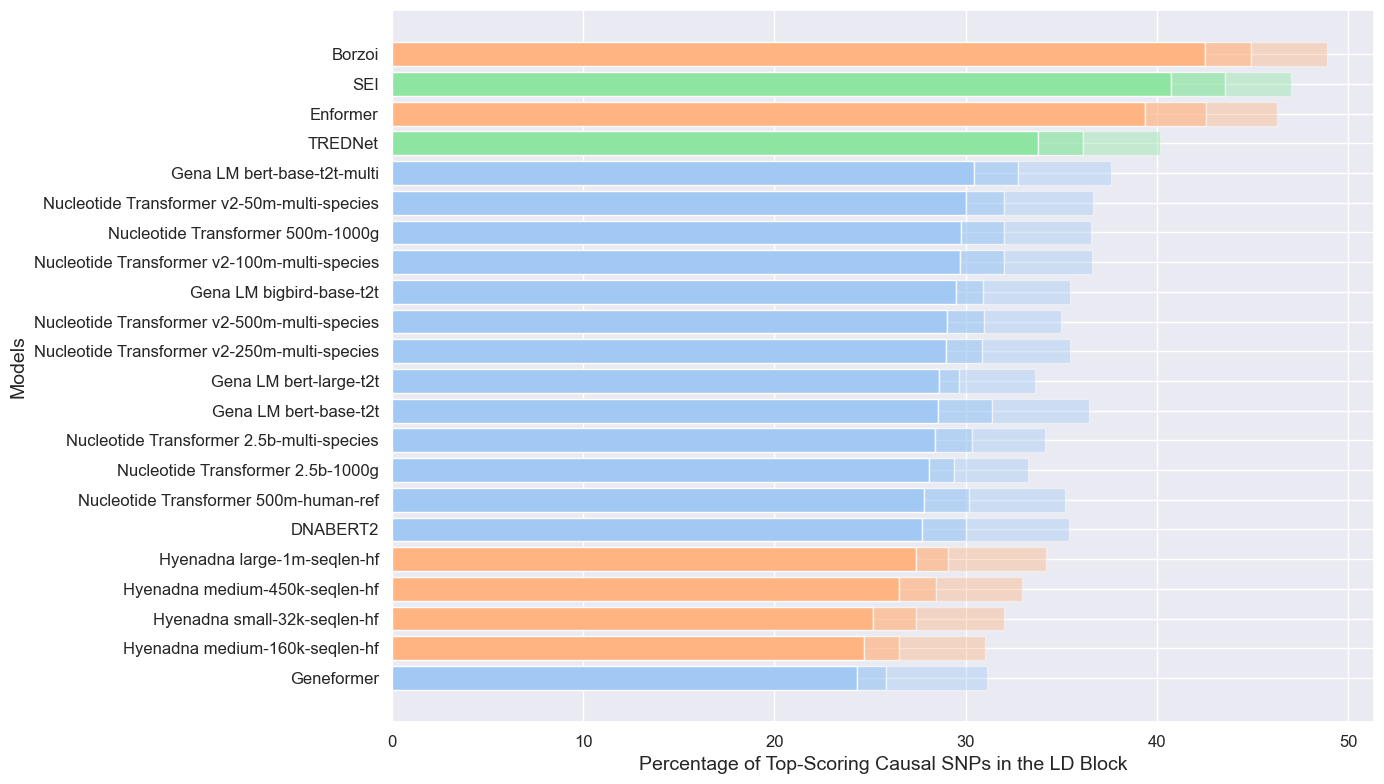

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style for Seaborn plots
sns.set()


# Architecture mapping
architecture_mapping = {
    'dnabert2': 'Transformer',
    'nucleotide-transformer-v2-50m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-100m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-250m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-500m-multi-species': 'Transformer',
    'nucleotide-transformer-500m-1000g': 'Transformer',
    'nucleotide-transformer-500m-human-ref': 'Transformer',
    'nucleotide-transformer-2.5b-1000g': 'Transformer',
    'nucleotide-transformer-2.5b-multi-species': 'Transformer',
    'Geneformer': 'Transformer',
    'gena-lm-bert-base-t2t': 'Transformer',
    'gena-lm-bert-large-t2t': 'Transformer',
    'gena-lm-bert-base-t2t-multi': 'Transformer',
    'gena-lm-bigbird-base-t2t': 'Transformer',
    'hyenadna-small-32k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-160k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-450k-seqlen-hf': 'Hybrid',
    'hyenadna-large-1m-seqlen-hf': 'Hybrid',
    'trednet': 'CNN',
    'sei': 'CNN',
    'enformer': 'Hybrid',
    'borzoi': 'Hybrid',
}

# Seaborn pastel color palette
palette = sns.color_palette("pastel", n_colors=len(set(architecture_mapping.values())))


# Color mapping based on architectures (using Set2 palette)
architecture_colors = {
    'Transformer': palette[0],  # First color for Transformer
    'Hybrid': palette[1],       # Second color for Hybrid
    'CNN': palette[2],          # Third color for CNN
}

# Normalize the values as percentage of the top value
data = model_to_casual_snp  # Assuming this contains model data

top_value = len(snp_cand_dict.keys())  # Assuming this is your dataset with causal SNP data
normalized_data = {
    model: {metric: (value[metric] / top_value) * 100 for metric in ['top_1', 'top_2', 'top_3']}
    for model, value in data.items()
}

# Convert the normalized data to a DataFrame
df = pd.DataFrame([
    {'Model': model, 'Metric': metric, 'Percentage': percentage, 'Architecture': architecture_mapping.get(model, 'Unknown')}
    for model, metrics in normalized_data.items()
    for metric, percentage in metrics.items()
])

# Architecture mapping for model names
architecture_mapping_models = {
    'dnabert2': 'DNABERT2',
    'nucleotide-transformer-v2-50m-multi-species':  'Nucleotide Transformer v2-50m-multi-species',
    'nucleotide-transformer-v2-100m-multi-species': 'Nucleotide Transformer v2-100m-multi-species',
    'nucleotide-transformer-v2-250m-multi-species': 'Nucleotide Transformer v2-250m-multi-species',
    'nucleotide-transformer-v2-500m-multi-species': 'Nucleotide Transformer v2-500m-multi-species',
    'nucleotide-transformer-500m-1000g':            'Nucleotide Transformer 500m-1000g',
    'nucleotide-transformer-500m-human-ref':        'Nucleotide Transformer 500m-human-ref',
    'nucleotide-transformer-2.5b-1000g':            'Nucleotide Transformer 2.5b-1000g',
    'nucleotide-transformer-2.5b-multi-species':    'Nucleotide Transformer 2.5b-multi-species',
    'Geneformer': 'Geneformer',
    'gena-lm-bert-base-t2t':        'Gena LM bert-base-t2t',
    'gena-lm-bert-large-t2t':       'Gena LM bert-large-t2t',
    'gena-lm-bert-base-t2t-multi':  'Gena LM bert-base-t2t-multi',
    'gena-lm-bigbird-base-t2t':     'Gena LM bigbird-base-t2t',
    'hyenadna-small-32k-seqlen-hf':   'Hyenadna small-32k-seqlen-hf',
    'hyenadna-medium-160k-seqlen-hf': 'Hyenadna medium-160k-seqlen-hf',
    'hyenadna-medium-450k-seqlen-hf': 'Hyenadna medium-450k-seqlen-hf',
    'hyenadna-large-1m-seqlen-hf':    'Hyenadna large-1m-seqlen-hf',
    'trednet': 'TREDNet',
    'sei': 'SEI',
    'enformer': 'Enformer',
    'borzoi': 'Borzoi',
}

# Add human-readable names for models (ensure architecture_mapping_models exists)
df['Model Name'] = df['Model']

# Sort the data by top_1 percentage for better comparison (ascending order)
df_sorted = df[df['Metric'] == 'top_1'].sort_values(by='Percentage', ascending=True)
order = df_sorted['Model'].tolist()

# Create a pivot table for stacked bars
df_pivot = df.pivot_table(index='Model Name', columns='Metric', values='Percentage', aggfunc=np.sum).fillna(0)


# Reorder the pivot table based on top_1 (ascending order)
df_pivot = df_pivot.loc[df_pivot['top_1'].sort_values(ascending=True).index]

# Create the plot with horizontal stacked bars
fig, ax = plt.subplots(figsize=(14, 8)) 

# Plot the bars with proper stacking
for i, model in enumerate(df_pivot.index):
    # Retrieve the architecture for the model from the pivoted DataFrame
    print(model)
    architecture = architecture_mapping.get(model, 'Unknown')
    
    # Get the color for top_1 based on the model architecture
    top_1_color = architecture_colors.get(architecture, '#000000')  # Default to black if not found
    


    # Plot top_1
    plt.barh(model, df_pivot.loc[model, 'top_1'], color=top_1_color, alpha = 1., label='Top 1' if i == 0 else "")
    
    # Plot top_2 - top_1
    plt.barh(model, df_pivot.loc[model, 'top_2'] - df_pivot.loc[model, 'top_1'], 
             left=df_pivot.loc[model, 'top_1'], color=top_1_color, alpha = 0.7, label='Top 2' if i == 0 else "")
    
    # Plot top_3 - top_2
    plt.barh(model, df_pivot.loc[model, 'top_3'] - df_pivot.loc[model, 'top_2'], 
             left=df_pivot.loc[model, 'top_2'], color=top_1_color, alpha = 0.4, label='Top 3' if i == 0 else "")

# Customize the appearance
plt.xlabel('Percentage of Top-Scoring Causal SNPs in the LD Block', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Adding titles and labels
y_labels = [architecture_mapping_models[model] for model in df_sorted['Model'].values]
ax.set_yticks(range(len(y_labels)))  # Set positions for y-ticks
ax.set_yticklabels(y_labels, fontsize=12)

# Remove the legend
plt.legend().remove()



# Adjust layout to avoid clipping
plt.tight_layout()
plt.savefig('figure3.png', dpi=300)
# Show the plot
plt.show()


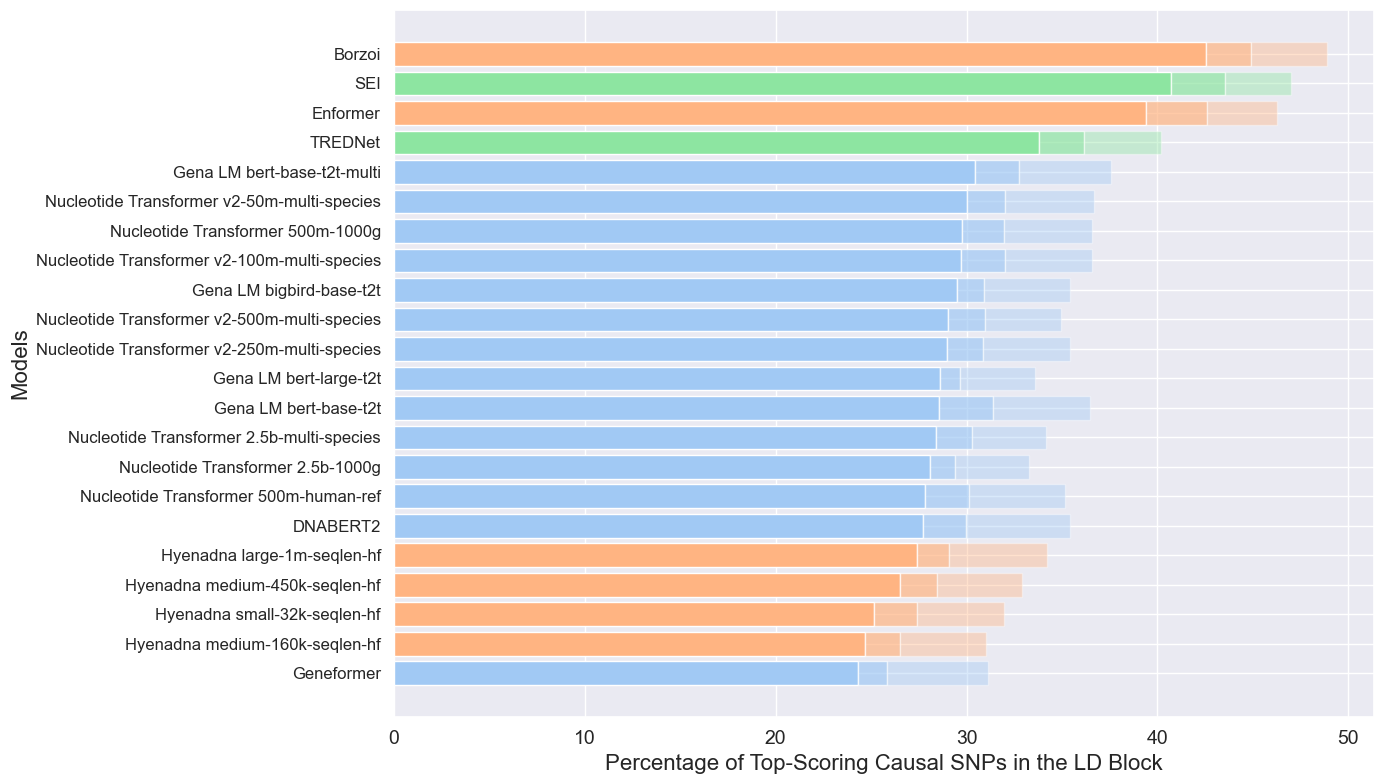

<Figure size 400x200 with 0 Axes>

<Figure size 400x200 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assume the preceding code for data preparation is already implemented...

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assume the preceding code for data preparation is already implemented...

# Create the horizontal stacked bar plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, model in enumerate(df_pivot.index):
    architecture = architecture_mapping.get(model, 'Unknown')
    top_1_color = architecture_colors.get(architecture, '#000000')  # Default to black if not found

    plt.barh(model, df_pivot.loc[model, 'top_1'], color=top_1_color, alpha=1.0, label='Top 1' if i == 0 else "")
    plt.barh(model, df_pivot.loc[model, 'top_2'] - df_pivot.loc[model, 'top_1'], 
             left=df_pivot.loc[model, 'top_1'], color=top_1_color, alpha=0.7, label='Top 2' if i == 0 else "")
    plt.barh(model, df_pivot.loc[model, 'top_3'] - df_pivot.loc[model, 'top_2'], 
             left=df_pivot.loc[model, 'top_2'], color=top_1_color, alpha=0.4, label='Top 3' if i == 0 else "")

# Customize the appearance
plt.xlabel('Percentage of Top-Scoring Causal SNPs in the LD Block', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

y_labels = [architecture_mapping_models[model] for model in df_sorted['Model'].values]
ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels, fontsize=12)

# Save the figure without the legend
plt.legend().remove()
plt.tight_layout()
plt.savefig('figure3.png', dpi=300)

# Extract and save the legend for top metrics
fig_legend = plt.figure(figsize=(4, 2))
handles, labels = ax.get_legend_handles_labels()
fig_legend.legend(handles, labels, loc='center', frameon=False, fontsize=12)
fig_legend.tight_layout()
fig_legend.savefig('figure3_legend_metrics.png', dpi=300)

# Extract and save the legend for model architectures
fig_arch_legend = plt.figure(figsize=(4, 2))
architecture_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in architecture_colors.values()]
architecture_labels = architecture_colors.keys()
fig_arch_legend.legend(architecture_handles, architecture_labels, loc='center', frameon=False, fontsize=12, title='Architectures')
fig_arch_legend.tight_layout()
fig_arch_legend.savefig('figure3_legend_architectures.png', dpi=300)

# Display the main figure
plt.show()
 


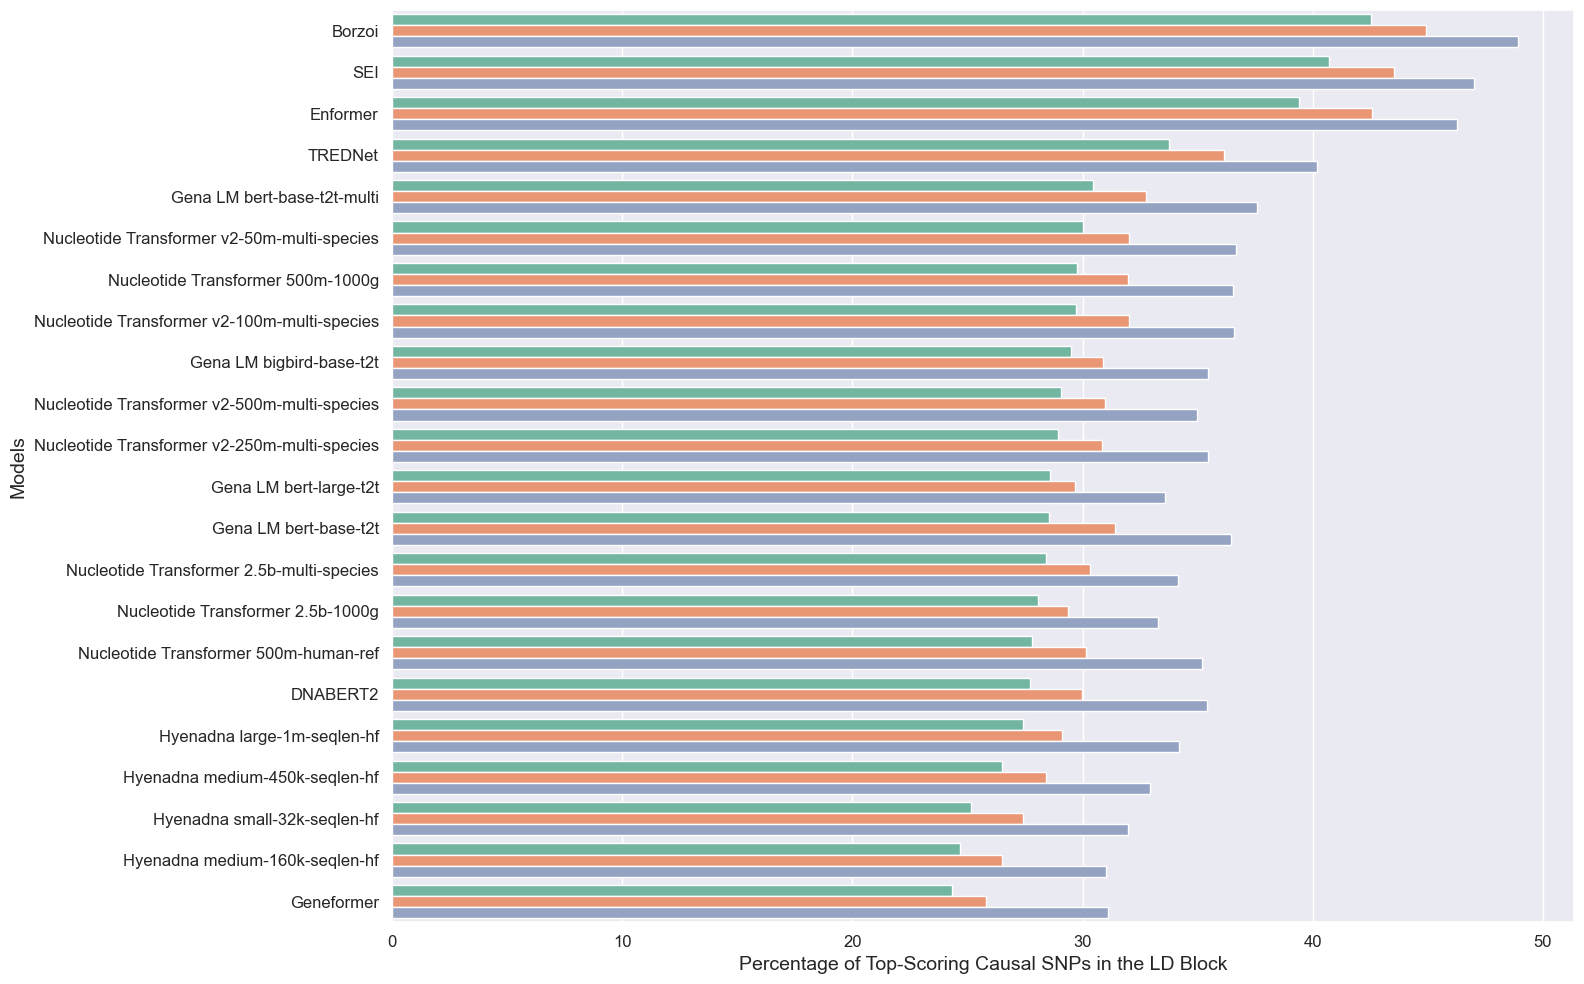

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style for Seaborn plots
sns.set()

# Normalize the values as percentage of the top value

data = model_to_casual_snp

top_value = len(snp_cand_dict.keys())
normalized_data = {
    model: {metric: (value[metric] / top_value) * 100 for metric in ['top_1', 'top_2', 'top_3']}
    for model, value in data.items()
}

# Convert the normalized data to a DataFrame
df = pd.DataFrame([
    {'Model': model, 'Metric': metric, 'Percentage': percentage, 'Architecture': architecture_mapping[model]}
    for model, metrics in normalized_data.items()
    for metric, percentage in metrics.items()
])

# Add human-readable names for models
df['Model Name'] = df['Model'].map(architecture_mapping_models)

# Sort the data by top_1 percentage for better comparison
df_sorted = df[df['Metric'] == 'top_1'].sort_values(by='Percentage', ascending=False)
order = df_sorted['Model'].tolist()

# Create the plot with horizontal bars
plt.figure(figsize=(16, 10))

# Use seaborn's barplot to create bars for top_1, top_2, and top_3
sns.barplot(
    x='Percentage',
    y='Model Name',
    hue='Metric',
    data=df,
    palette='Set2',  # Different palette for clearer distinction
    order=[architecture_mapping_models[model] for model in order],
)

# Customize the appearance
plt.xlabel('Percentage of Top-Scoring Causal SNPs in the LD Block', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.legend([],[], frameon=False)
# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()


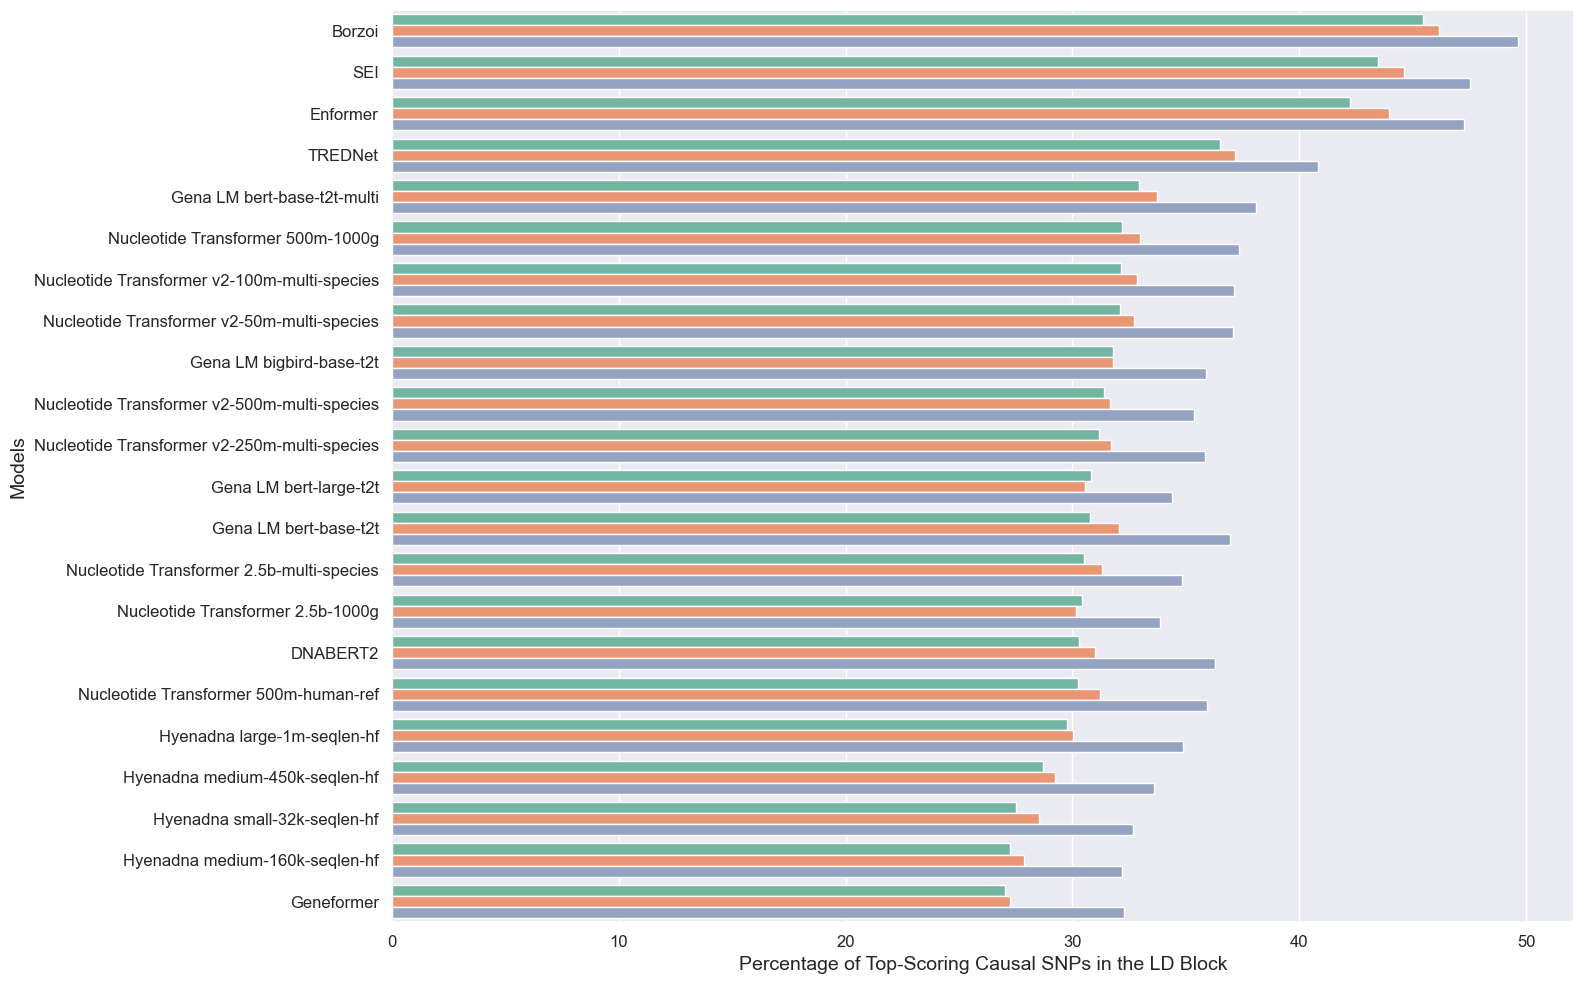

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style for Seaborn plots
sns.set()

# Normalize the values as percentage of the top value

data = model_to_casual_snp_no_overlap

top_value = len(causal_snp_list_no_overlaps)
normalized_data = {
    model: {metric: (value[metric] / top_value) * 100 for metric in ['top_1', 'top_2', 'top_3']}
    for model, value in data.items()
}

# Convert the normalized data to a DataFrame
df = pd.DataFrame([
    {'Model': model, 'Metric': metric, 'Percentage': percentage, 'Architecture': architecture_mapping[model]}
    for model, metrics in normalized_data.items()
    for metric, percentage in metrics.items()
])

# Add human-readable names for models
df['Model Name'] = df['Model'].map(architecture_mapping_models)

# Sort the data by top_1 percentage for better comparison
df_sorted = df[df['Metric'] == 'top_1'].sort_values(by='Percentage', ascending=False)
order = df_sorted['Model'].tolist()

# Create the plot with horizontal bars
plt.figure(figsize=(16, 10))

# Use seaborn's barplot to create bars for top_1, top_2, and top_3
sns.barplot(
    x='Percentage',
    y='Model Name',
    hue='Metric',
    data=df,
    palette='Set2',  # Different palette for clearer distinction
    order=[architecture_mapping_models[model] for model in order],
)

# Customize the appearance
plt.xlabel('Percentage of Top-Scoring Causal SNPs in the LD Block', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.legend([],[], frameon=False)
# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()


## Overlap

### check overlap

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="muted")

# Load narrowPeak file into a DataFrame
def load_narrowpeak(file_path):
    """
    Reads a narrowPeak BED file and returns a pandas DataFrame.
    """
    column_names = [
        "Chromosome", "Start", "End", "Name", "Score", "Strand",
        "SignalValue", "pValue", "qValue", "Peak"
    ]
    df = pd.read_csv(file_path, sep="\t", header=None, names=column_names)
    return df

# Plot chromosomal profile for a specific 2kbp region as a pin plot
def plot_kbp_region_pinplot(df, chrom="chr1", snp_pos=1000000, value_column="SignalValue"):
    """
    Plots a chromosomal profile for a specific 2kbp region as a pin plot.
    """
    # Filter data for the specified chromosome and region
    df_filtered = df[(df["Chromosome"] == chrom) & 
                     (df["Start"] <= snp_pos) & 
                     (df["End"] >= snp_pos)]
    
    if df_filtered.empty:
       # print(f"No peaks found in the specified region for {chrom}.")
        return

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot the data as a pin plot (using vertical lines)
    for _, row in df_filtered.iterrows():
        plt.plot([row["Start"], row["Start"]], [0, row[value_column]], color="skyblue", lw=2)  # Pin line
        plt.scatter(row["Start"], row[value_column], color="blue", s=50, zorder=5)  # Pin head (point)

    # Customize plot
    
    plt.xlabel("Base Pair Position", fontsize=12)
    plt.ylabel(value_column, fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# File path to the narrowPeak file
file_path = "/data/Dcode/gaetano/repos/AI4Genomic/data/h3k27ac/hepg2_hg38/ENCFF886SZT.bed"
# Load the DataFrame
df_narrowpeak_k27ac = load_narrowpeak(file_path)
# Plot for a specific 2kbp region on chromosome 10 (e.g., from 100005828 to 100101693)
plot_kbp_region_pinplot(df_narrowpeak_k27ac, chrom="chr11", snp_pos=56168524, value_column="SignalValue")


# File path to the narrowPeak file
file_path = "/data/Dcode/gaetano/repos/AI4Genomic/data/atac-seq/hepg2_hg38/ENCFF439EIO.bed"
# Load the DataFrame
df_narrowpeak_atac = load_narrowpeak(file_path)
# Plot for a specific 2kbp region on chromosome 10 (e.g., from 100005828 to 100101693)
plot_kbp_region_pinplot(df_narrowpeak_atac, chrom="chr11", snp_pos=56168524, value_column="SignalValue")


# File path to the narrowPeak file
file_path = "/data/Dcode/gaetano/repos/AI4Genomic/data/DNase/hepg2_hg38/ENCFF375MTY.bed"
# Load the DataFrame
df_narrowpeak_dnase = load_narrowpeak(file_path)
# Plot for a specific 2kbp region on chromosome 10 (e.g., from 100005828 to 100101693)
plot_kbp_region_pinplot(df_narrowpeak_dnase, chrom="chr11", snp_pos=56168524, value_column="SignalValue")

In [25]:
## check if the snp is in the peak
def intersection_bed_files(df, chrom="chr1", snp_pos=1000000):
    df_filtered = df[(df["Chromosome"] == chrom) & 
                     (df["Start"] <= snp_pos) & 
                     (df["End"] >= snp_pos)]
    
    return not df_filtered.empty

In [27]:
idx=0
chrom = df['Chromosome'].iloc[idx]
snp_pos = df['Position'].iloc[idx]
print(intersection_bed_files(df_narrowpeak_k27ac, chrom=chrom, snp_pos=snp_pos))
print(intersection_bed_files(df_narrowpeak_atac, chrom=chrom, snp_pos=snp_pos))
print(intersection_bed_files(df_narrowpeak_dnase, chrom=chrom, snp_pos=snp_pos))

False
False
False


In [ ]:
## load dataframe 
with open(f"/data/Dcode/gaetano/repos/AI4Genomic/data/ld/ld_df_{data_['name']}.pkl", "rb") as pickle_file:
    df = pickle.load(pickle_file)

print(f"Loaded LD dataframe for {data_['name']}")

Loaded LD dataframe for hepg2.sign.id.LP190708.txt


In [ ]:
df

,Chromosome,Position,Reference,Alternative,SNP_id,SNP_id_candidate
0,chr3,30093762,C,T,rs1368858,rs1821390
1,chr3,30094871,G,A,rs4426643,rs1821390
2,chr3,30095414,T,C,rs6771354,rs1821390
3,chr3,30093245,A,G,rs4435584,rs1821390
4,chr14,88921367,G,T,rs61982562,rs7156067
...,...,...,...,...,...,...
239059,chr5,131412310,C,G,rs140083600,rs73786649
239060,chr5,131549073,A,T,rs58993531,rs73786649
239061,chr5,131469726,T,C,rs73786680,rs73786649
239062,chr5,131308265,C,T,rs543881749,rs73786649


In [ ]:
df[df['SNP_id_candidate']=='rs1821390']

,Chromosome,Position,Reference,Alternative,SNP_id,SNP_id_candidate
0,chr3,30093762,C,T,rs1368858,rs1821390
1,chr3,30094871,G,A,rs4426643,rs1821390
2,chr3,30095414,T,C,rs6771354,rs1821390
3,chr3,30093245,A,G,rs4435584,rs1821390


In [ ]:
# Plot for a specific 2kbp region on chromosome 10 (e.g., from 100005828 to 100101693)
k27ac, atac, dnase = [] , [], []

for idx, row in df.iterrows():
    chrom = row['Chromosome']
    snp_pos = row['Position']
    k27ac.append(intersection_bed_files(df_narrowpeak_k27ac, chrom=chrom, snp_pos=snp_pos))
    atac.append(intersection_bed_files(df_narrowpeak_atac, chrom=chrom, snp_pos=snp_pos))
    dnase.append(intersection_bed_files(df_narrowpeak_dnase, chrom=chrom, snp_pos=snp_pos))
    if idx > 1000:
        break

## Extra

Loaded DataFrame:
  Chromosome      Start        End        Name  Score Strand  SignalValue  \
0      chr10  100005828  100006246  Peak_67702     12      .      3.63019   
1      chr10  100009273  100009655  Peak_27518     22      .      7.78643   
2      chr10  100038053  100039830  Peak_10420     69      .     18.08505   
3      chr10  100080967  100082211  Peak_17727     38      .     12.05081   
4      chr10  100095102  100095563  Peak_48111     14      .      4.64480   

     pValue    qValue  Peak  
0   4.27906   2.42468   265  
1  13.37992  11.21485   227  
2  54.50574  51.74897   563  
3  27.24070  24.82194   814  
4   6.17626   4.22877   327  


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


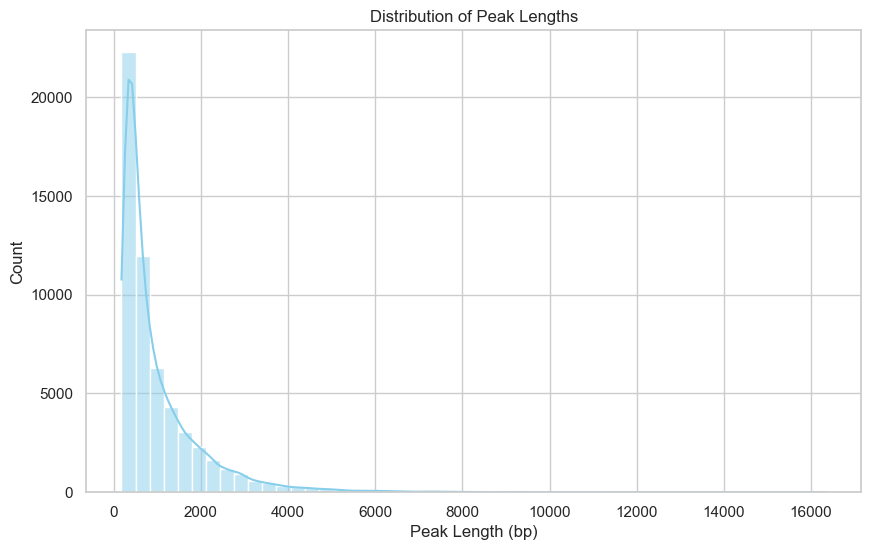

/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


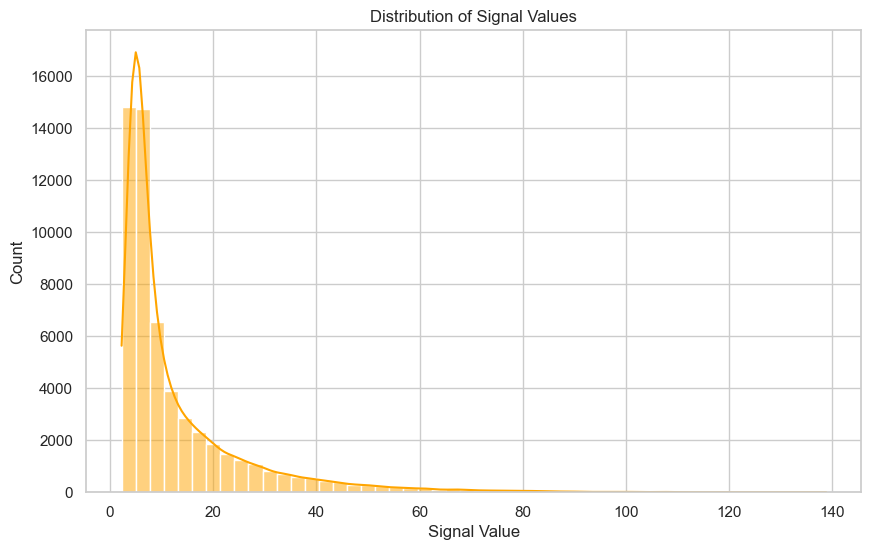

/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


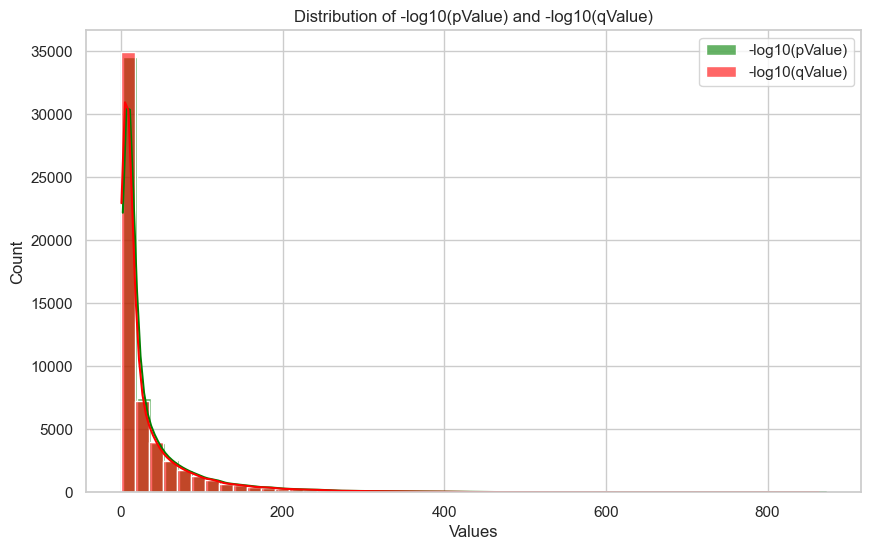

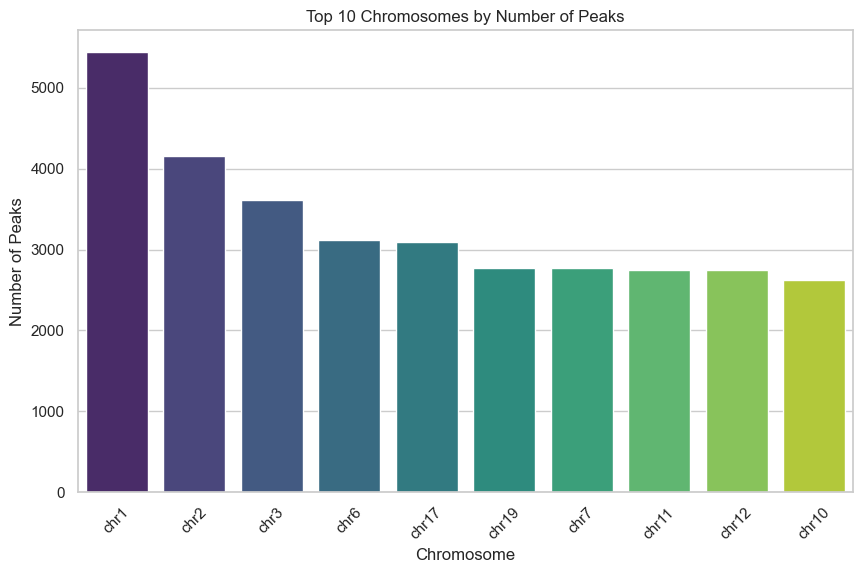

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="pastel")

# Load narrowPeak file into a DataFrame
def load_narrowpeak(file_path):
    """
    Reads a narrowPeak BED file and returns a pandas DataFrame.
    """
    column_names = [
        "Chromosome", "Start", "End", "Name", "Score", "Strand",
        "SignalValue", "pValue", "qValue", "Peak"
    ]
    df = pd.read_csv(file_path, sep="\t", header=None, names=column_names)
    return df

# Plot the data
def plot_narrowpeak(df):
    """
    Plots key statistics from the narrowPeak DataFrame.
    """
    # Add 'Length' column
    df["Length"] = df["End"] - df["Start"]
    
    # 1. Plot distribution of peak lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(df["Length"], bins=50, color="skyblue", kde=True)
    plt.title("Distribution of Peak Lengths")
    plt.xlabel("Peak Length (bp)")
    plt.ylabel("Count")
    plt.show()
    
    # 2. Plot distribution of Signal Value
    plt.figure(figsize=(10, 6))
    sns.histplot(df["SignalValue"], bins=50, color="orange", kde=True)
    plt.title("Distribution of Signal Values")
    plt.xlabel("Signal Value")
    plt.ylabel("Count")
    plt.show()
    
    # 3. Plot distribution of -log10(pValue) and -log10(qValue)
    plt.figure(figsize=(10, 6))
    sns.histplot(df["pValue"], bins=50, color="green", kde=True, label="-log10(pValue)", alpha=0.6)
    sns.histplot(df["qValue"], bins=50, color="red", kde=True, label="-log10(qValue)", alpha=0.6)
    plt.title("Distribution of -log10(pValue) and -log10(qValue)")
    plt.xlabel("Values")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    
    # 4. Top 10 chromosomes by number of peaks
    plt.figure(figsize=(10, 6))
    chromosome_counts = df["Chromosome"].value_counts().head(10)
    sns.barplot(x=chromosome_counts.index, y=chromosome_counts.values, palette="viridis")
    plt.title("Top 10 Chromosomes by Number of Peaks")
    plt.xlabel("Chromosome")
    plt.ylabel("Number of Peaks")
    plt.xticks(rotation=45)
    plt.show()

# File path to the narrowPeak file
file_path = "/data/Dcode/gaetano/repos/AI4Genomic/data/h3k27ac/hepg2_hg38/ENCFF886SZT.bed"

# Run the functions
df_narrowpeak = load_narrowpeak(file_path)
print("Loaded DataFrame:")
print(df_narrowpeak.head())

plot_narrowpeak(df_narrowpeak)


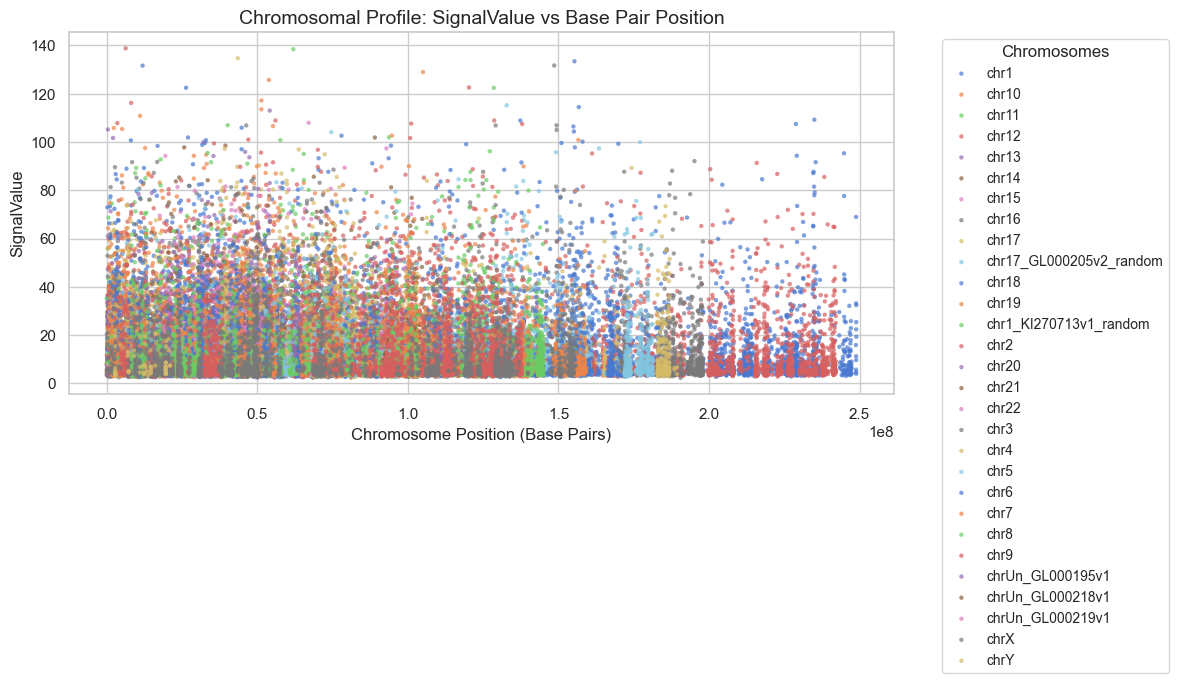

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", palette="muted")

# Load narrowPeak file into a DataFrame
def load_narrowpeak(file_path):
    """
    Reads a narrowPeak BED file and returns a pandas DataFrame.
    """
    column_names = [
        "Chromosome", "Start", "End", "Name", "Score", "Strand",
        "SignalValue", "pValue", "qValue", "Peak"
    ]
    df = pd.read_csv(file_path, sep="\t", header=None, names=column_names)
    return df

# Plot chromosomal profile
def plot_chromosomal_profile(df, value_column="SignalValue"):
    """
    Plots a chromosomal profile where x-axis represents base pairs from chr1 to chrX
    and y-axis represents the peak value (SignalValue or Score).
    """
    # Sort by Chromosome and Start position
    df_sorted = df.sort_values(by=["Chromosome", "Start"])

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Convert Chromosome to categorical ordering to plot in correct order
    chrom_order = sorted(df_sorted["Chromosome"].unique(), key=lambda x: (x[3:], x))  # Sorting chromosomes as chr1, chr2, ..., chrX

    # Plot each chromosome's peaks
    for chrom in chrom_order:
        chrom_data = df_sorted[df_sorted["Chromosome"] == chrom]
        
        # Plot each peak in the chromosome
        plt.scatter(
            chrom_data["Start"], chrom_data[value_column], 
            s=10, label=f"{chrom}", alpha=0.7, edgecolors="none"
        )
        
        # Optionally, you can plot as a line plot instead of scatter by using:
        # plt.plot(chrom_data["Start"], chrom_data[value_column], label=f"{chrom}", alpha=0.7)

    # Customize plot
    plt.title(f"Chromosomal Profile: {value_column} vs Base Pair Position", fontsize=14)
    plt.xlabel("Chromosome Position (Base Pairs)", fontsize=12)
    plt.ylabel(value_column, fontsize=12)
    plt.legend(title="Chromosomes", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()

# File path to the narrowPeak file
file_path = "/data/Dcode/gaetano/repos/AI4Genomic/data/h3k27ac/hepg2_hg38/ENCFF886SZT.bed"

# Load and plot the data
df_narrowpeak = load_narrowpeak(file_path)
plot_chromosomal_profile(df_narrowpeak, value_column="SignalValue")


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


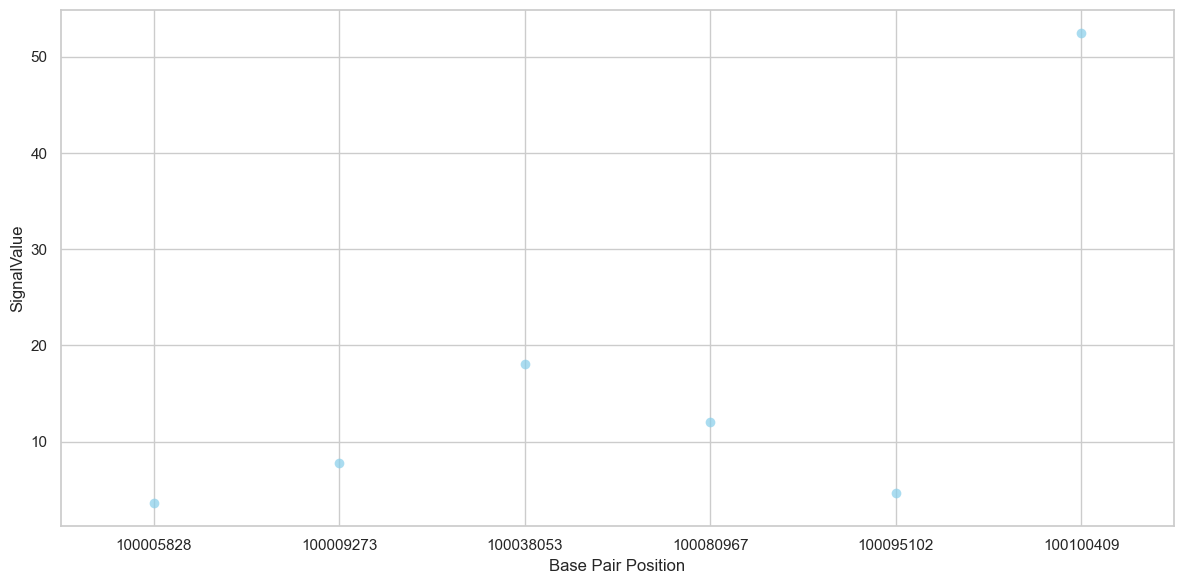

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="muted")

# Load narrowPeak file into a DataFrame
def load_narrowpeak(file_path):
    """
    Reads a narrowPeak BED file and returns a pandas DataFrame.
    """
    column_names = [
        "Chromosome", "Start", "End", "Name", "Score", "Strand",
        "SignalValue", "pValue", "qValue", "Peak"
    ]
    df = pd.read_csv(file_path, sep="\t", header=None, names=column_names)
    return df

# Plot chromosomal profile for a specific 2kbp region as a strip plot
def plot_kbp_region_stripplot(df, chrom="chr1", start_bp=1000000, end_bp=1002000, value_column="SignalValue"):
    """
    Plots a chromosomal profile for a specific 2kbp region as a strip plot.
    """
    # Filter data for the specified chromosome and region
    df_filtered = df[(df["Chromosome"] == chrom) & 
                     (df["Start"] >= start_bp) &
                     (df["End"] <= end_bp)]
    
    if df_filtered.empty:
        print(f"No peaks found in the specified 2kbp region for {chrom}.")
        return

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot the data as a strip plot
    sns.stripplot(
        x="Start", 
        y=value_column, 
        data=df_filtered, 
        color="skyblue", 
        size=7,  # Controls the size of the dots
        jitter=True,  # Adds some random jitter to make the dots more distinguishable
        alpha=0.7  # Transparency of the dots
    )

    # Customize plot
    plt.xlabel("Base Pair Position", fontsize=12)
    plt.ylabel(value_column, fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# File path to the narrowPeak file
file_path = "/data/Dcode/gaetano/repos/AI4Genomic/data/h3k27ac/hepg2_hg38/ENCFF886SZT.bed"

# Load the DataFrame
df_narrowpeak = load_narrowpeak(file_path)

# Plot for a specific 2kbp region on chromosome 10 (e.g., from 100005828 to 100006246)
plot_kbp_region_stripplot(df_narrowpeak, chrom="chr10", start_bp=100005828, end_bp=100101693, value_column="SignalValue")


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


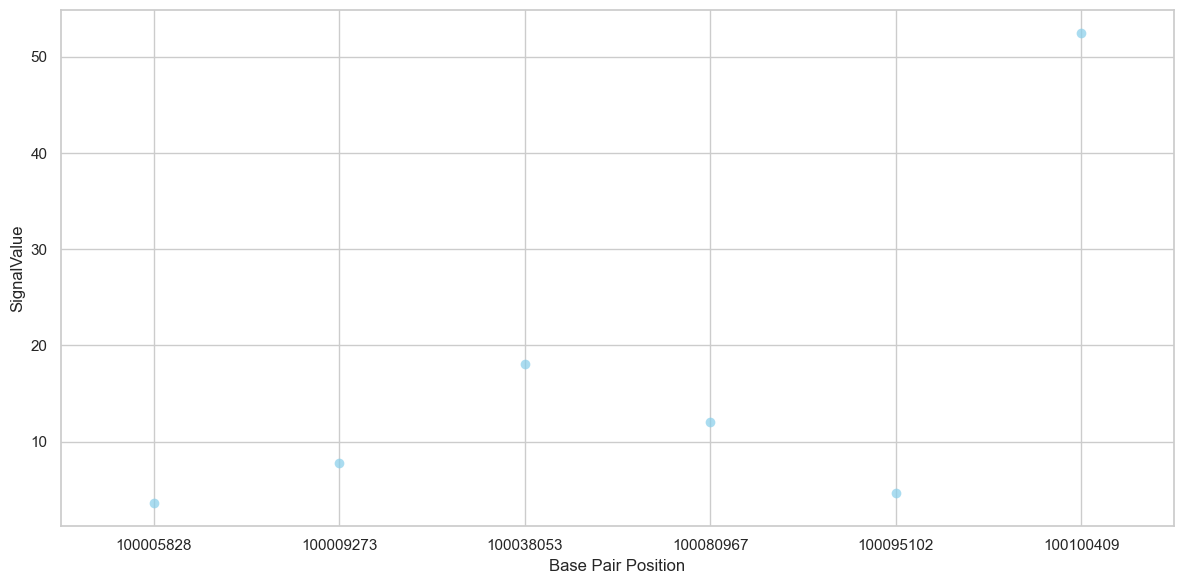

In [ ]:
# Plot for a specific 2kbp region on chromosome 10 (e.g., from 100005828 to 100006246)
plot_kbp_region_stripplot(df_narrowpeak, chrom="chr10", start_bp=100005828, end_bp=100101693, value_column="SignalValue")